# Legacy mode

This example demonstrates how to use GLASS in a FLASK-like "legacy mode", where both matter and convergence fields are simulated for a given set of n(z).

It is generally **not recommended** to run simulations in this manner: as one can see below, the very small lognormal shifts of the convergence fields mean the lognormal transformation is overall ill-defined, and the simulated angular power spectra require regularisation. In other words, the simulation has to run with slightly different spectra than predicted by theory. This doesn't generally happen with "GLASS-like" simulations.

## Setup

We begin by setting up the simulation. First, import some required libraries.

In [ ]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

Also import GLASS.

In [ ]:
import glass
import glass.ext.camb

Define a function for plotting spectra.

In [ ]:
def plot_spectra(*spectra, labels=[], log=True):
    nspec = max(len(cls) for cls in spectra)
    nfields = glass.fields.inv_triangle_number(nspec)
    fig, ax = plt.subplots(
        nfields, nfields, figsize=(1.1 * nfields, 1.0 * nfields), sharex=True, sharey=True, layout="constrained",
    )

    for (i, j), *spec in zip(glass.spectra_indices(nfields), *spectra):
        ax[i, j].tick_params(axis="both", which="both", direction="in")
        for c, cl in enumerate(spec):
            if log:
                ax[i, j].plot(np.arange(1, cl.size), +cl[1:], alpha=0.5, c=f"C{c}")
                ax[i, j].plot(np.arange(1, cl.size), -cl[1:], alpha=0.5, c=f"C{c}", ls="--")
            else:
                ax[i, j].plot(np.arange(cl.size), cl, alpha=0.5, c=f"C{c}")

    for i, j in zip(*np.triu_indices(nfields, 1)):
        ax[i, j].axis("off")

    ax[0, 1].legend(
        handles=[
            plt.Line2D([0], [0], c=f"C{c}", label=label) for c, label in enumerate(labels)
        ],
        loc="lower left",
        frameon=False,
        fontsize=6,
        borderpad=0.0,
        borderaxespad=0.0,
    )

    if log:
        ax[0, 0].set_xscale("log")
        ax[0, 0].set_yscale("log")

    return fig, ax

## Inputs

At first, we will use GLASS to define some mock redshift distributions. These could come, e.g., from a galaxy survey.

In [ ]:
z = np.arange(0.0, 5.01, 0.01)

dndz = glass.smail_nz(z, 1.0, 1.5, 2.0)

nbins = 6
zbins = glass.equal_dens_zbins(z, dndz, nbins)

nz = glass.tomo_nz_gausserr(z, dndz, 0.05, zbins)

Plot the redshift distributions — these are pretty much arbitrary and only for illustration purposes.

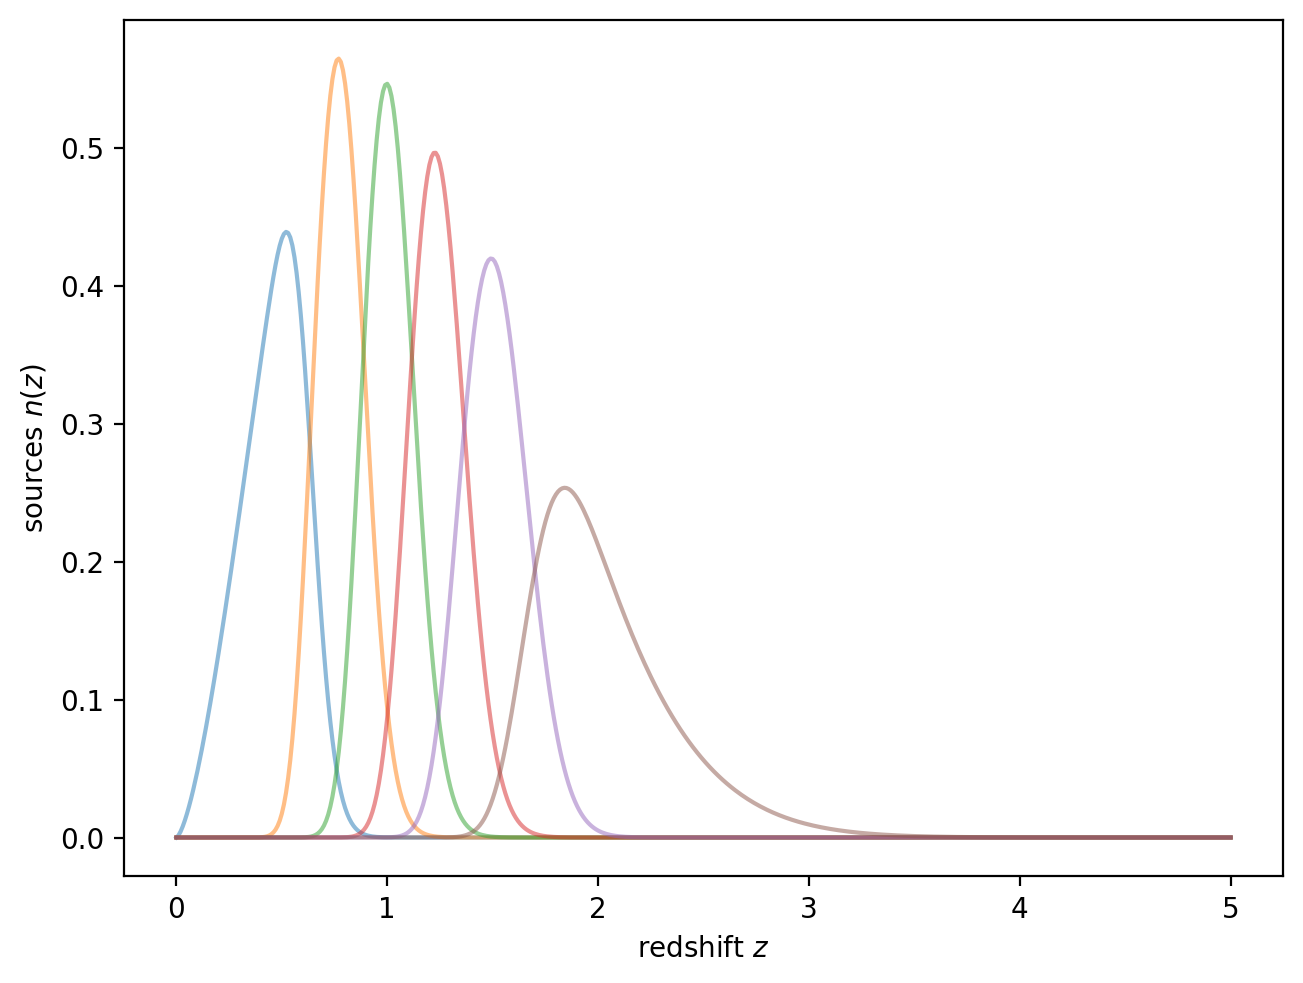

In [ ]:
plt.figure(layout="constrained")
plt.plot(z, nz.T, alpha=0.5)
plt.xlabel("redshift $z$")
plt.ylabel("sources $n(z)$")
plt.show()

We will use the first set of bins for galaxy density, and the second set of bins for convergence. This is completely arbitrary, and only used to make bookkeeping easier.

In [ ]:
# density
nz_1 = nz[:3]

# convergence
nz_2 = nz[3:]

Now we can compute the input theory spectra of the fields to be simulated. Here, we use CAMB.

In [ ]:
import camb
import camb.sources
from cosmology import Cosmology

rng = np.random.default_rng(seed=42)

h = 0.7
Oc = 0.25
Ob = 0.05

nside = lmax = 256

pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

pars.set_accuracy(AccuracyBoost=2.0, lAccuracyBoost=2.0, lSampleBoost=2.0)
pars.Want_CMB = False
pars.Want_CMB_lensing = False
pars.min_l = 1
pars.set_for_lmax(2 * lmax)

pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=nz_i, source_type="counts") for nz_i in nz_1
] + [
    camb.sources.SplinedSourceWindow(z=z, W=nz_i, source_type="lensing") for nz_i in nz_2
]

cls_dict = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

After the spectra are computed, we collect them into a list in the order that GLASS expects, using `glass.spectra_indices()`.

In [ ]:
cls = [cls_dict[f"W{i+1}xW{j+1}"] for i, j in glass.spectra_indices(nbins)]

Plot the spectra using the function defined above.

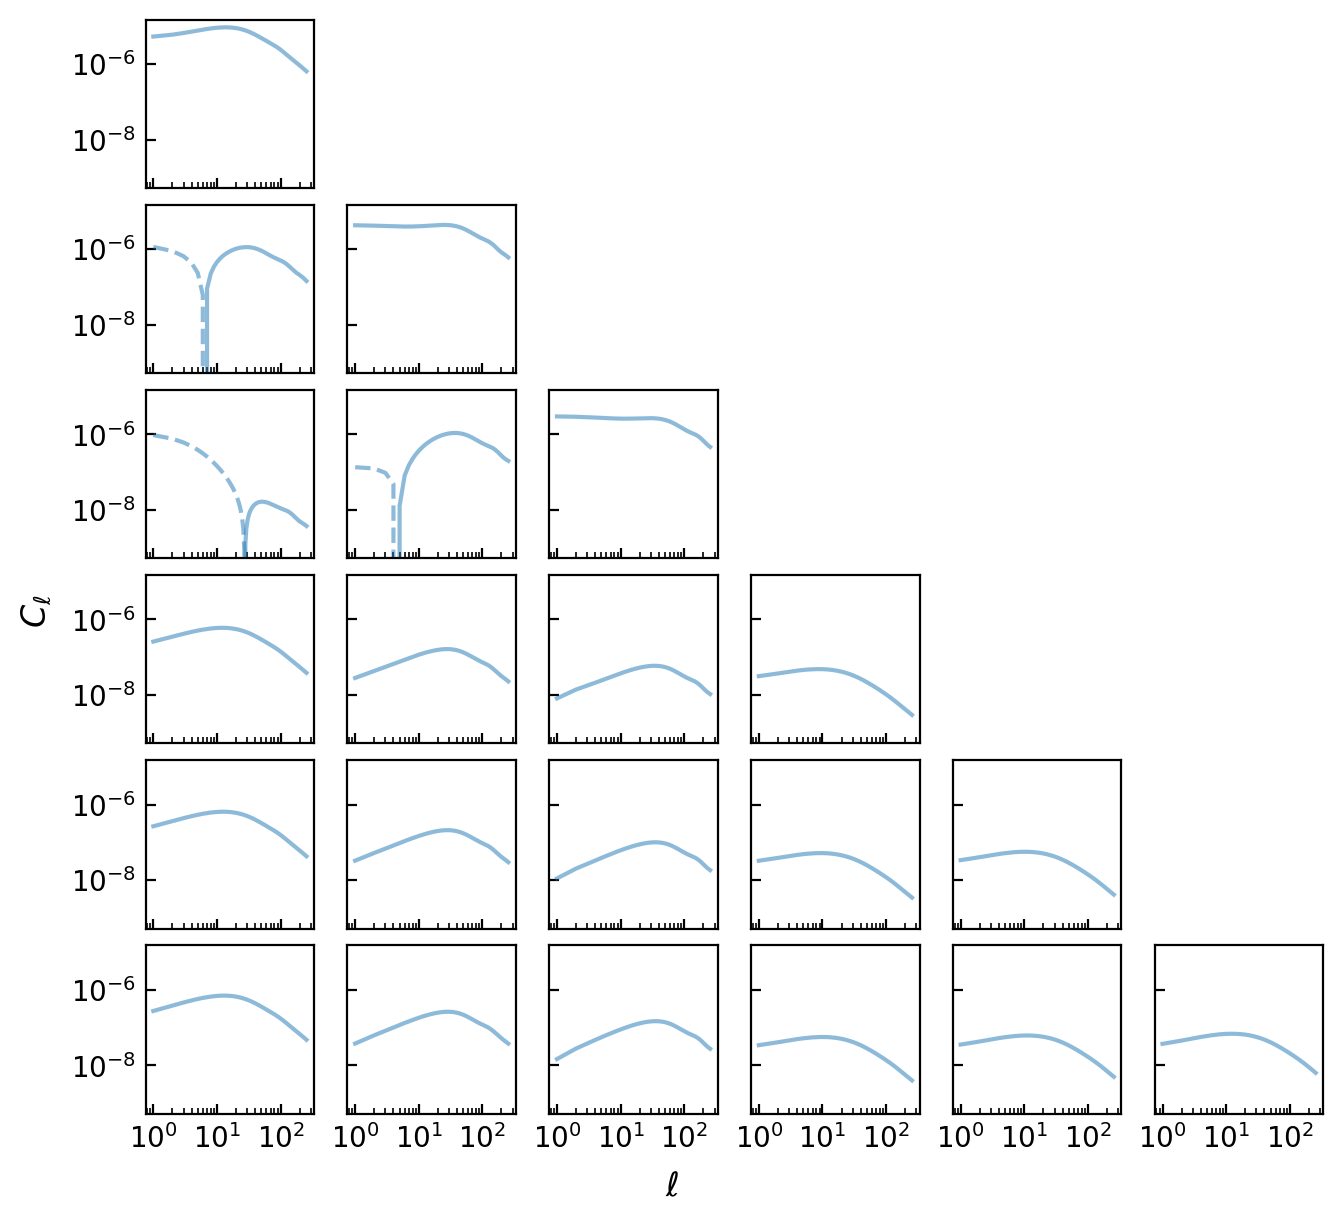

In [ ]:
fig, ax = plot_spectra(cls)

fig.supxlabel("$\\ell$")
fig.supylabel("$C_\\ell$")

plt.show()

## Prepare simulation

Now we can prepare the GLASS simulation. For "legacy mode", we turn the redshift distributions into (improper) GLASS "shells", by manually creating `glass.RadialWindow()` instances. Here, the "shells" do not have to be strictly increasing in redshift, since we do not compute the weak lensing iteratively, but simulate it all in one go.

In [ ]:
shells_1 = [
    glass.RadialWindow(z, nz_i, np.trapezoid(z * nz_i, z) / np.trapezoid(nz_i, z)) for nz_i in nz_1
]
shells_2 = [
    glass.RadialWindow(z, nz_i, np.trapezoid(z * nz_i, z) / np.trapezoid(nz_i, z)) for nz_i in nz_2
]

We can then set up the lognormal fields for the "shells". The density fields get assigned a fixed lognormal shift of 1 (i.e. the default). The convergence fields get assigned a redshift-dependent lognormal shift from the fit by Hilbert et al. (2011).

In [ ]:
# density
fields_1 = glass.lognormal_fields(shells_1)

# convergence
fields_2 = glass.lognormal_fields(shells_2, glass.lognormal_shift_hilbert2011)

We then combine the density and convergence fields into one single set, and compute their Gaussian angular power spectra for simulation using GLASS's iterative solver.

In [ ]:
fields = fields_1 + fields_2

gls = glass.solve_gaussian_spectra(fields, cls)

Plotting both lognormal and Gaussian spectra shows the impact of the small lognormal shift on the convergence fields.

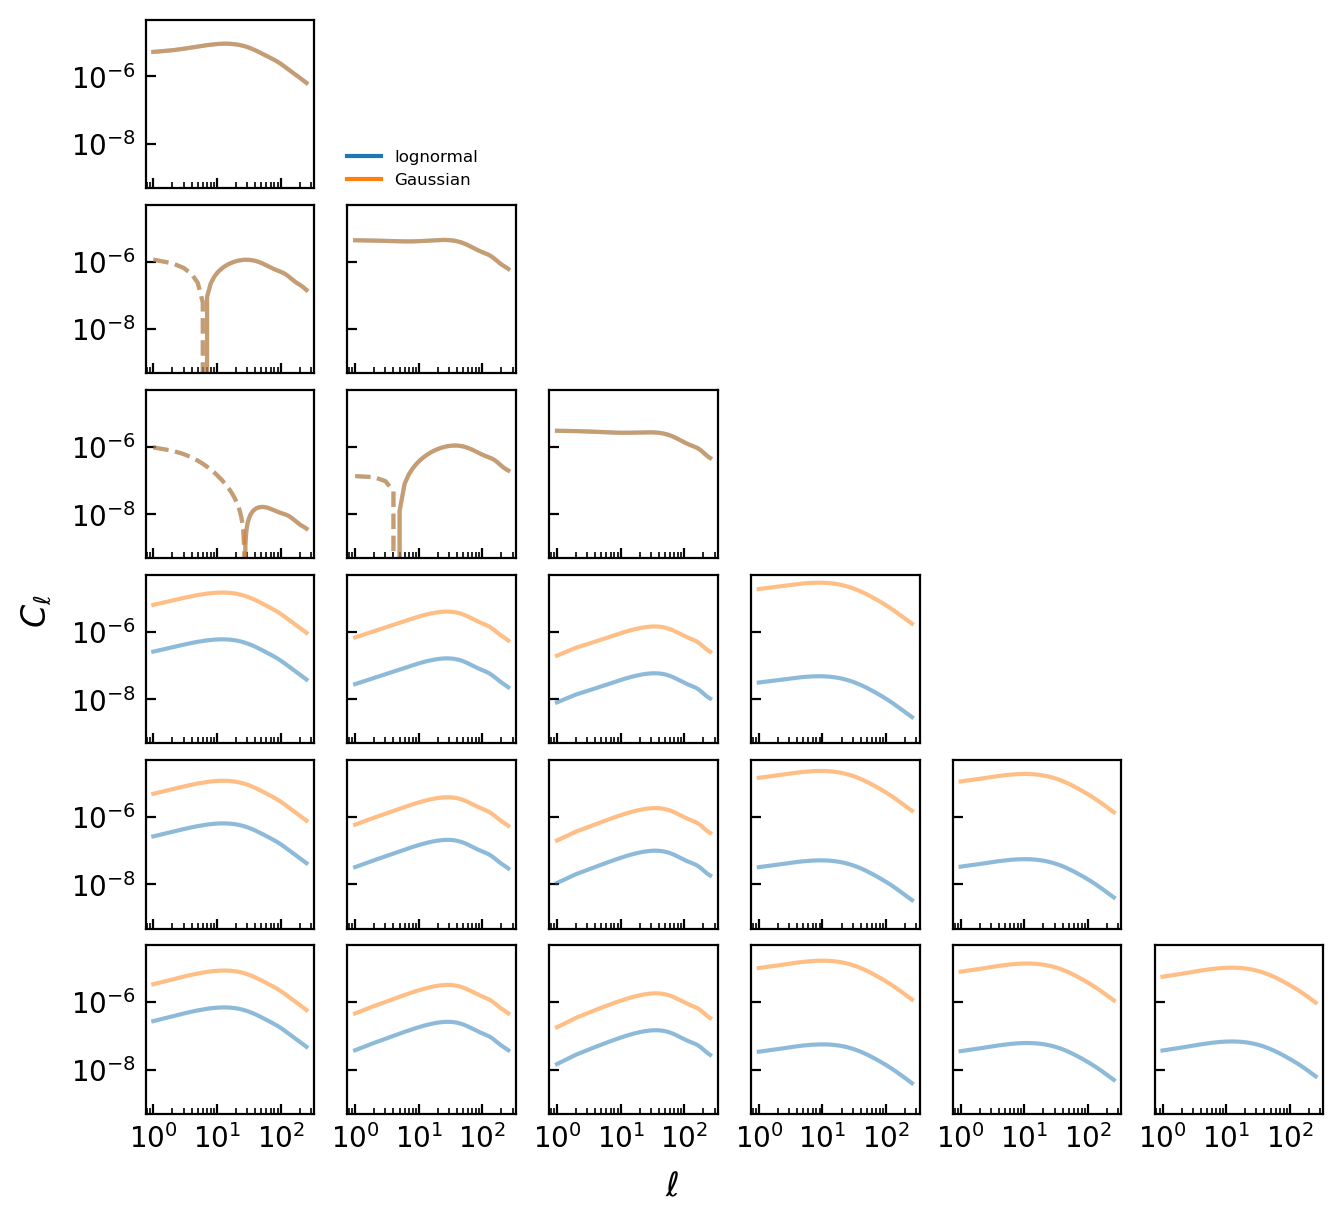

In [ ]:
fig, ax = plot_spectra(cls, gls, labels=["lognormal", "Gaussian"])

fig.supxlabel("$\\ell$")
fig.supylabel("$C_\\ell$")

plt.show()

## Regularise spectra

The very small lognormal shifts of the convergence fields, coupled with the fact that the line-of-sight kernel for weak lensing overlaps that of the density fields, means the fields have a complicated correlation structure. To visualise this, we can compute the per-$\ell$ correlation coefficient $R_\ell$ (see GLASS paper for details) for all fields.

In [ ]:
rls = []
for (i, j), gl in zip(glass.spectra_indices(nbins), gls):
    gl_ii, gl_jj = glass.getcl(gls, i, i), glass.getcl(gls, j, j)
    with np.errstate(invalid="ignore"):
        rl = gl / np.sqrt(gl_ii * gl_jj)
    rls.append(rl)

Plotting the resulting $R_\ell$ shows the very strong correlations between the fields.

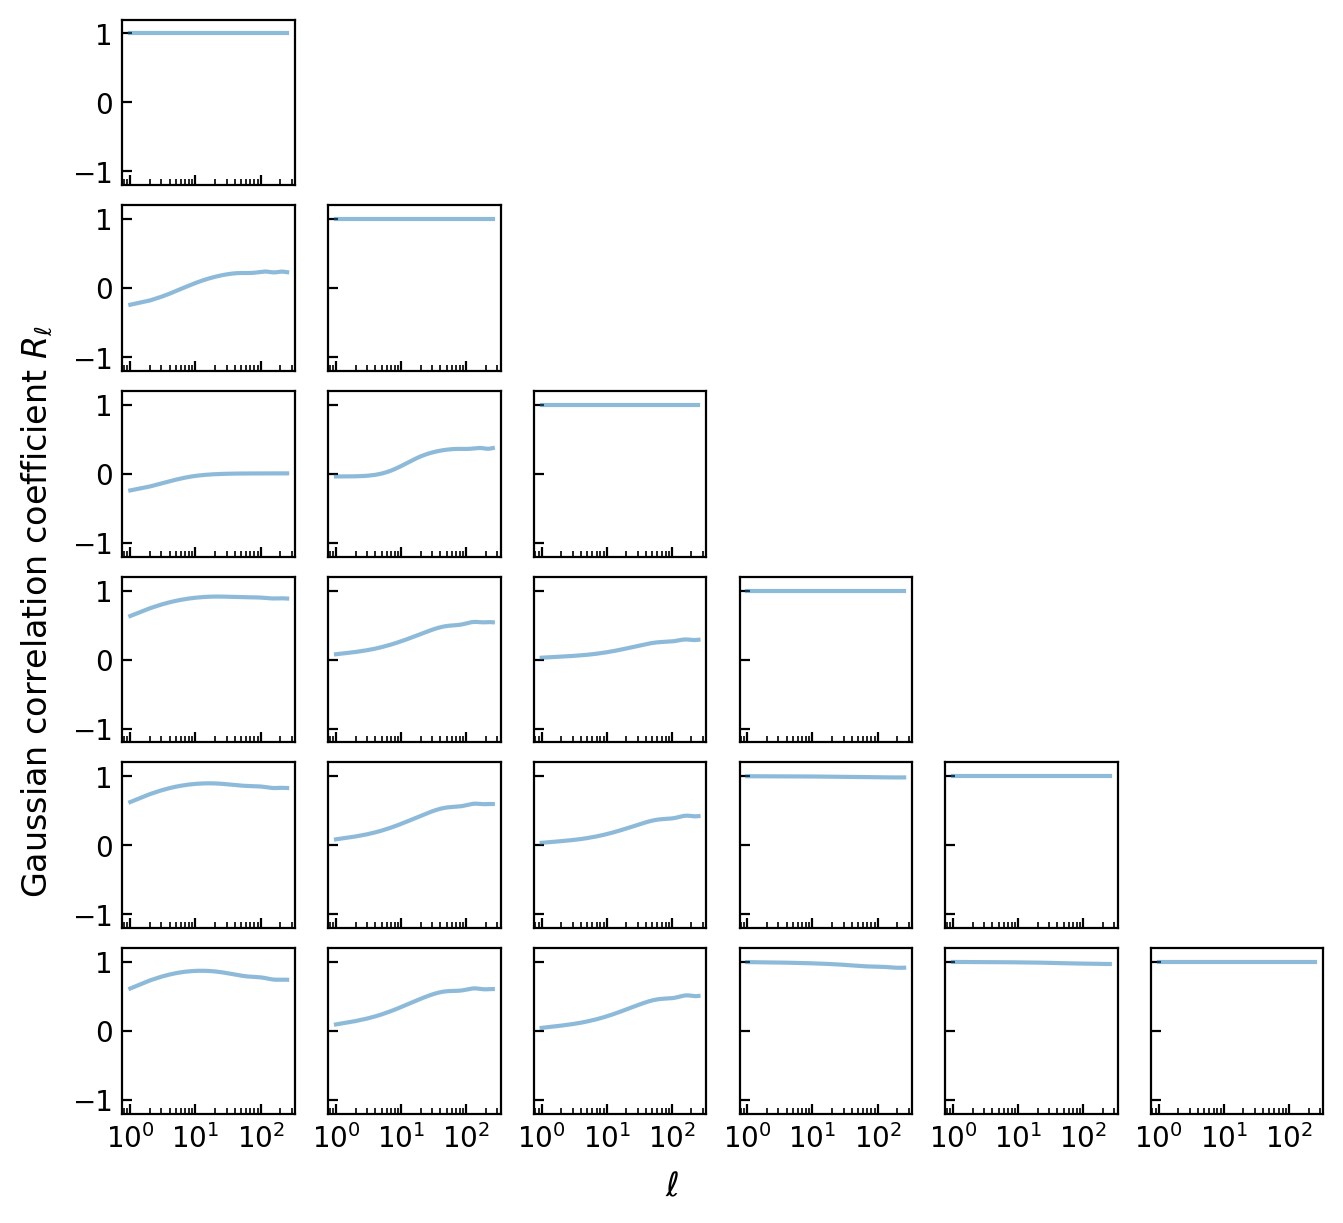

In [ ]:
fig, ax = plot_spectra(rls, log=False)
    
ax[0, 0].set_xscale("log")
ax[0, 0].set_ylim(-1.2, 1.2)

fig.supxlabel("$\\ell$")
fig.supylabel("Gaussian correlation coefficient $R_\\ell$")

plt.show()

The problem with such strong correlations is that they cannot be realised by actual Gaussian random fields. In other words, when trying to sample fields from these Gaussian angular power spectra, we would find that the associated covariance matrix is not positive (semi-)definite. GLASS comes with a function to check this.

In [ ]:
glass.check_posdef_spectra(gls)

np.False_

However, GLASS also comes with a function to "regularise" the spectra. There are multiple ways an indefinite covariance matrix could be "regularised". The default method in GLASS is to find the nearest valid correlation matrix, which keeps the auto-spectra of the fields unchanged.

In [ ]:
reg_gls = glass.regularized_spectra(gls)

After regularisation, the spectra form a valid covariance matrix.

In [ ]:
glass.check_posdef_spectra(reg_gls)

np.True_

And, thanks to the "nearest correlation matrix" approach, the Gaussian angular spectra themselves have changed very little due to regularisation.

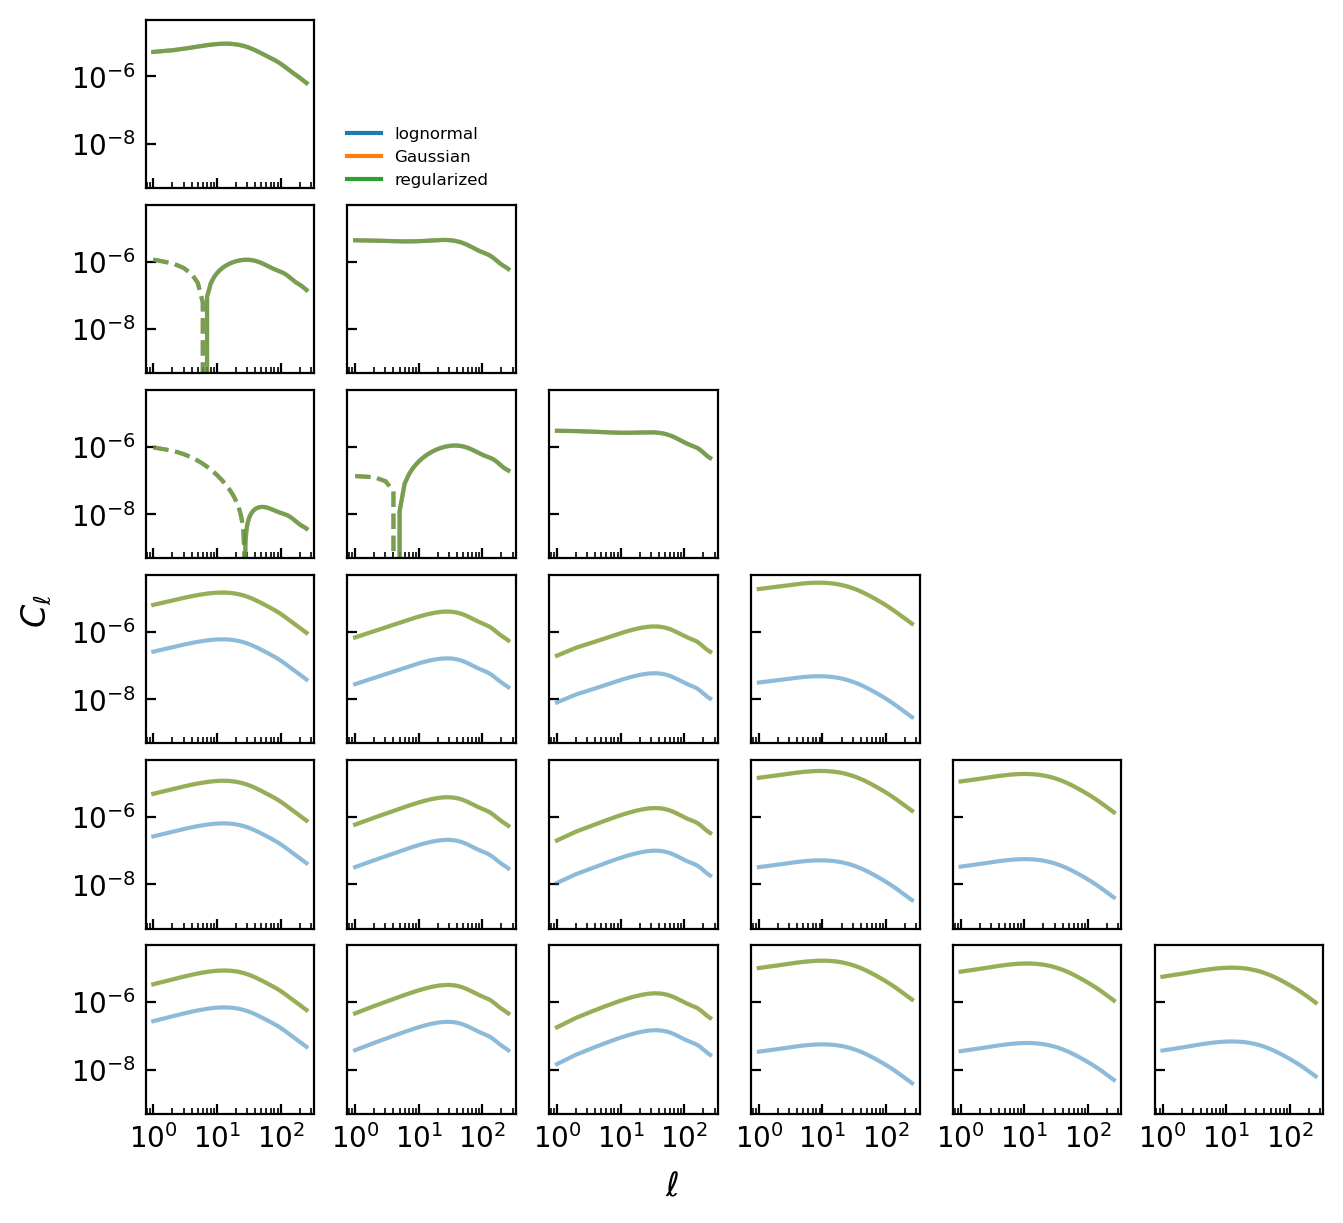

In [ ]:
fig, ax = plot_spectra(cls, gls, reg_gls, labels=["lognormal", "Gaussian", "regularized"])

fig.supxlabel("$\\ell$")
fig.supylabel("$C_\\ell$")

plt.show()

With the Gaussian angular power spectra fixed, we are finally ready to simulate the fields.

## Simulate

The simulation in "legacy mode" requires all simulated random fields to be correlated. We can therefore carry it out in one go, converting the iterator normally returned by `glass.generate()` into a list of all maps.

In [ ]:
maps = list(glass.generate(fields, reg_gls, nside))

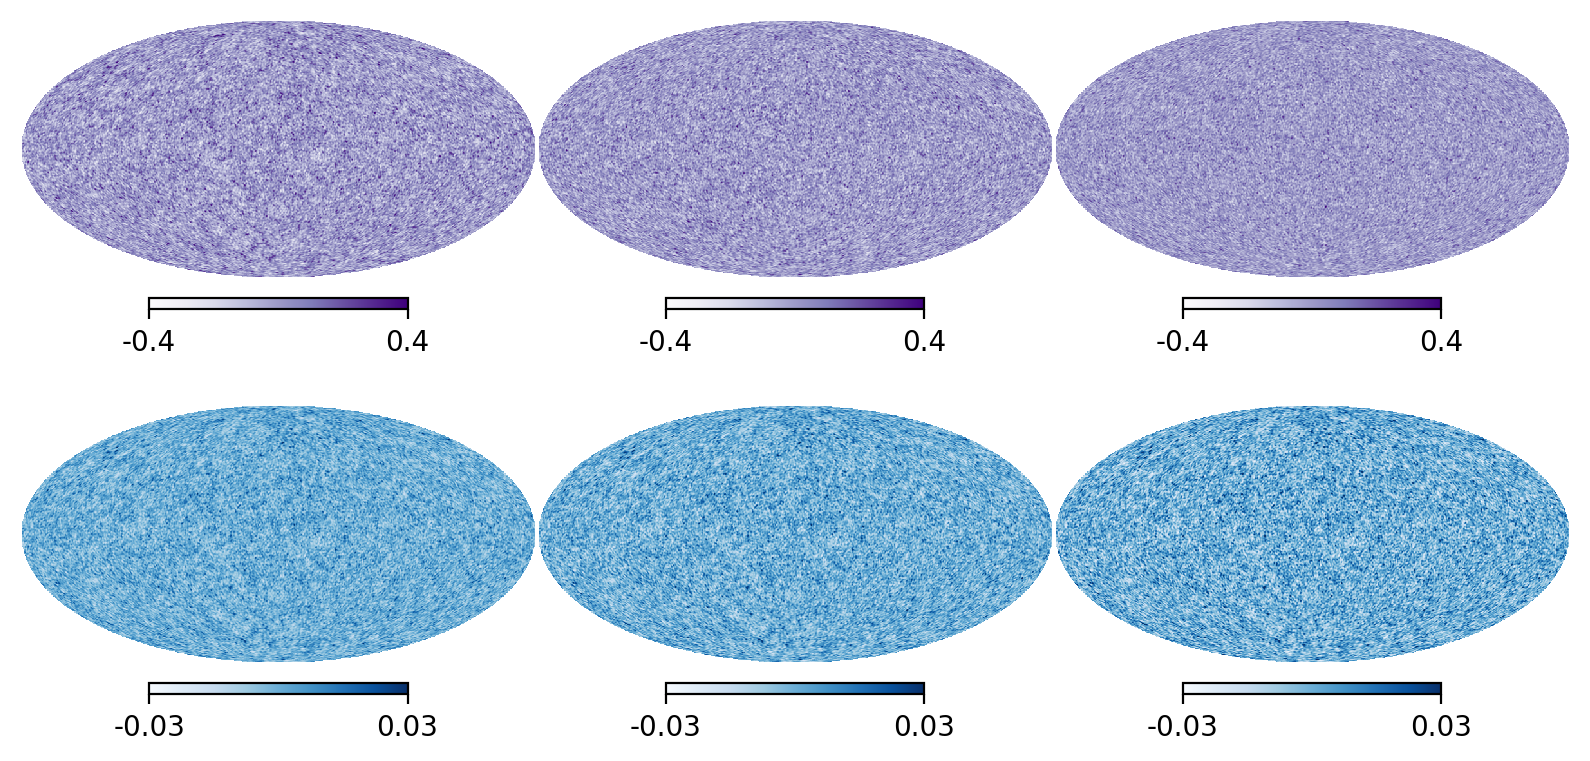

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5))

fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i, m in enumerate(maps[:3]):
    plt.sca(ax[0, i])
    hp.mollview(m, title=None, hold=True, cmap="Purples", min=-0.4, max=0.4)

for i, m in enumerate(maps[3:]):
    plt.sca(ax[1, i])
    hp.mollview(m, title=None, hold=True, cmap="Blues", min=-0.03, max=0.03)

plt.show()

We can then compute the realised lognormal angular power spectra from the maps. A helper function converts the output from HEALPix order to GLASS order.

In [ ]:
cls_sim = hp.anafast(maps, lmax=lmax, pol=False, use_pixel_weights=True)

# reorder spectra from HEALPix to GLASS order
cls_sim = glass.healpix_to_glass_spectra(cls_sim)

Thanks to the power of GLASS, the realised lognormal fields correspond very well to the input spectra!

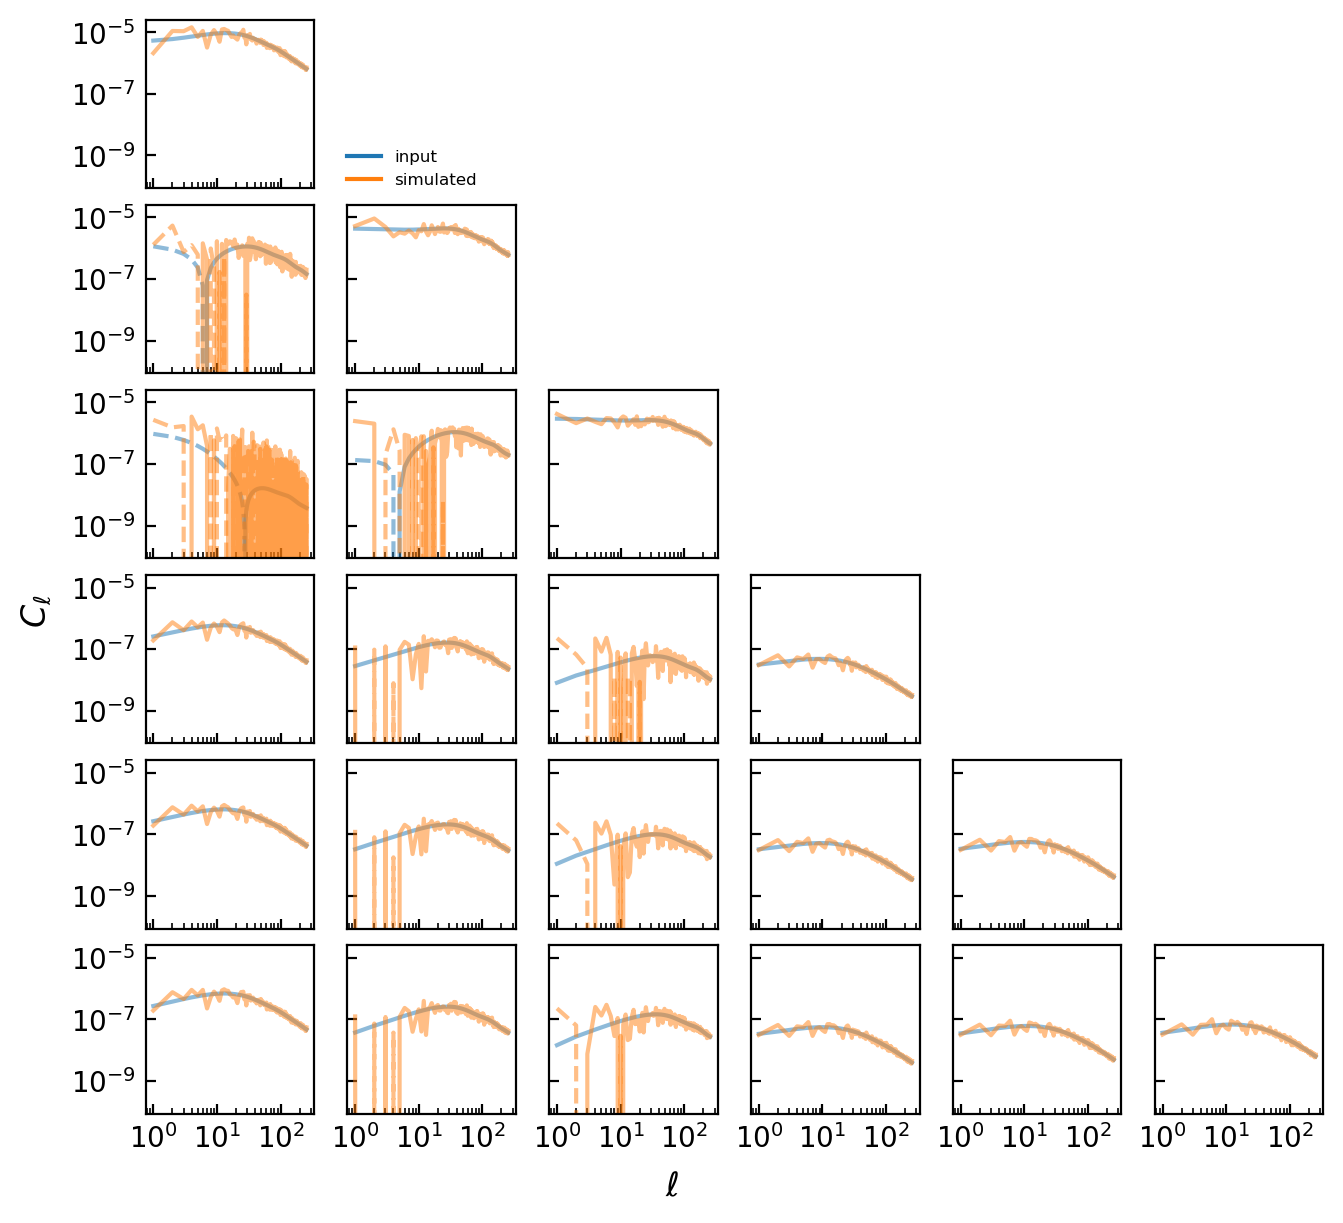

In [ ]:
fig, ax = plot_spectra(cls, cls_sim, labels=["input", "simulated"])

fig.supxlabel("$\\ell$")
fig.supylabel("$C_\\ell$")

plt.show()